# Tomato Disease Detection using Convolutional Neural Network (CNN)

### 1.Importing all the librarires

In [ ]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
import numpy as np
import pandas as pd
import random
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from tabulate import tabulate

### 2.Loading Datasets

In [ ]:
# defining constants
BATCH_SIZE = 32
IMG_SIZE = 256
EPOCHS = 50
CHANNELS=3

In [ ]:
#creating a tf.data.Dataset for building a input pipeline for your ML model.
dataset=tf.keras.utils.image_dataset_from_directory(
   "Data",
    shuffle=True,
    image_size=(IMG_SIZE,IMG_SIZE),
    batch_size=BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


In [ ]:
# getting class names
class_names = dataset.class_names
class_names

['Bacterial_spot',
 'Early_blight',
 'Healthy',
 'Late_blight',
 'Leaf_Mold',
 'Mosaic_virus',
 'Septoria_leaf_spot',
 'Spider_mites',
 'Target_Spot',
 'YellowLeaf__Curl_Virus']

In [ ]:
#showing the batch classes
for image_batch,labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[9 6 9 2 9 8 0 9 9 3 6 3 2 3 6 9 9 9 2 7 7 6 6 0 1 0 8 9 2 6 0 8]


### 3. Data Visualization

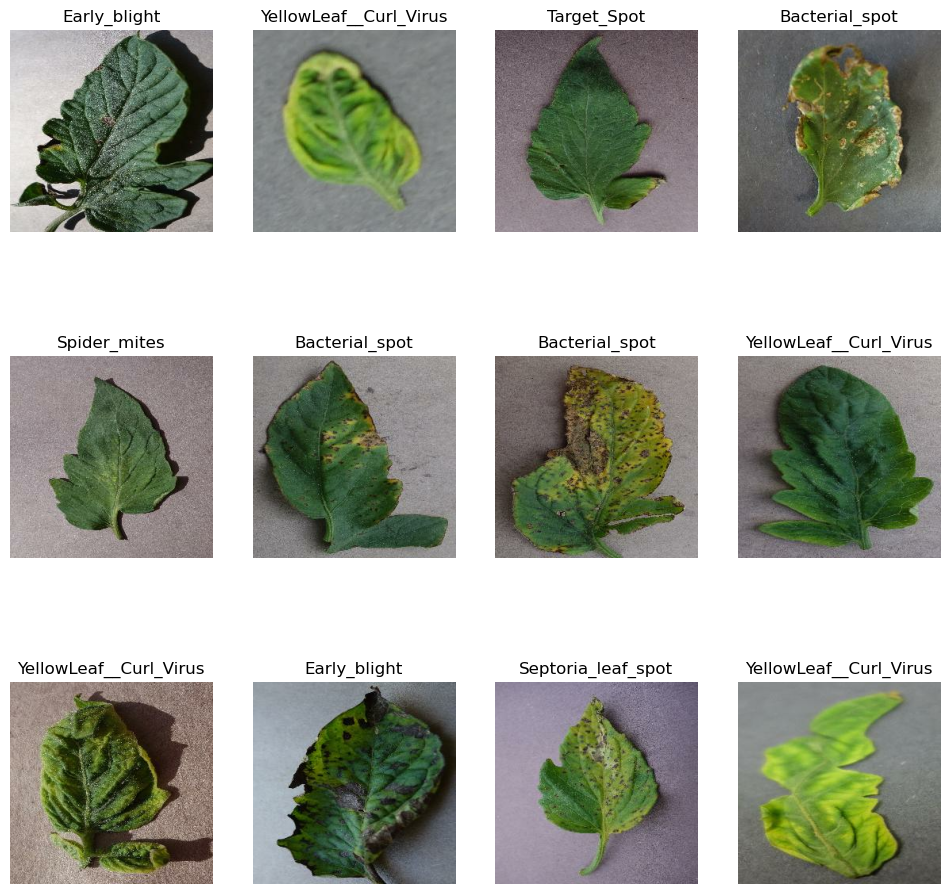

In [ ]:
plt.figure(figsize=(12, 12))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## 4. Data Preprocessing

#### 4.1  Spliting Dataset into Training, Validation and Test
- Training-72%
- Validation-18%
- Test-10%

In [ ]:
# creating training set, validation set and testing set
ds_size = len(dataset)

dataset = dataset.shuffle(10000, seed=12)

# taking 10% for testing set and dividing remaining into 80/20 training/validation ratio
train_size = int(ds_size * 0.72) # 72%
train_ds = dataset.take(train_size)

val_size = int(ds_size * 0.18) # 18%
val_ds = dataset.skip(train_size).take(val_size)

test_ds = dataset.skip(train_size).skip(val_size)
test_size = len(test_ds) # 10%

print(f'Dataset size   : {ds_size}')
print(f'Train set size : {train_size}')
print(f'Val set size   : {val_size}')
print(f'Test set size  : {test_size}')

Dataset size   : 501
Train set size : 360
Val set size   : 90
Test set size  : 51


#### 4.2 Optimizing tf input data pipeline performance
Cache, Shuffle, and Prefetch the Dataset


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

#### 4.3 Resizing and Rescaling layers


In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255),# rescaling/normalising rgb values to between 0.0 and 1.0
])

#### 4.4 Data augmentation to make model robust and prevent overfitting

In [ ]:
data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

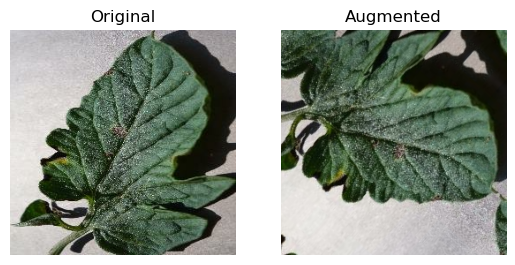

In [ ]:
# testing data augmentation
imgs = [image_batch[0].numpy().astype('uint8'), data_aug(image_batch[0]).numpy().astype('uint8')]
titles = ['Original', 'Augmented']
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(imgs[i])
    plt.title(titles[i])
    plt.axis('off')

In [ ]:
# applying data augmentation to training set
train_ds = train_ds.map(
    lambda x, y: (data_aug(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


## 5. Model Building
### Using  Convolutional Neural Network (CNN)

#### 5.1 Model Architecture
We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

In [ ]:
# building model with alternating Conv2D and MaxPooling2D layers
input_shape = (BATCH_SIZE, IMG_SIZE, IMG_SIZE, 3) # 3 channels - rgb
n_classes = len(class_names)

model = models.Sequential([
  resize_and_rescale, # layers.InputLayer(input_shape=input_shape) # using data generator
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(units=64, activation='relu'),
    layers.Dense(units=n_classes, activation='softmax')
])


In [ ]:
model.build(input_shape=input_shape)

In [ ]:
model.summary() # all trainable parameters

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (32, 60, 60, 64)         

In [ ]:
# compiling model with optimizer, loss and metrics
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
# Train the model
history=model.fit(train_ds, batch_size=BATCH_SIZE, validation_data=val_ds,verbose=1, epochs=50)

Epoch 1/50
360/360 [==============================] - 502s 1s/step - loss: 1.7497 - accuracy: 0.3702 - val_loss: 1.3725 - val_accuracy: 0.5073
Epoch 2/50
360/360 [==============================] - 411s 1s/step - loss: 1.1470 - accuracy: 0.5858 - val_loss: 0.9638 - val_accuracy: 0.6736
Epoch 3/50
360/360 [==============================] - 401s 1s/step - loss: 0.7619 - accuracy: 0.7254 - val_loss: 1.0030 - val_accuracy: 0.6771
Epoch 4/50
360/360 [==============================] - 398s 1s/step - loss: 0.5847 - accuracy: 0.7913 - val_loss: 1.0076 - val_accuracy: 0.7264
Epoch 5/50
360/360 [==============================] - 380s 1s/step - loss: 0.4990 - accuracy: 0.8249 - val_loss: 1.2753 - val_accuracy: 0.6604
Epoch 6/50
360/360 [==============================] - 409s 1s/step - loss: 0.4286 - accuracy: 0.8458 - val_loss: 0.5351 - val_accuracy: 0.8170
Epoch 7/50
360/360 [==============================] - 383s 1s/step - loss: 0.3803 - accuracy: 0.8636 - val_loss: 0.7012 - val_accuracy: 0.7823

### Plotting the Accuracy and Loss Curves

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.749690055847168,
 1.1470063924789429,
 0.7619260549545288,
 0.5847296118736267,
 0.498972088098526]

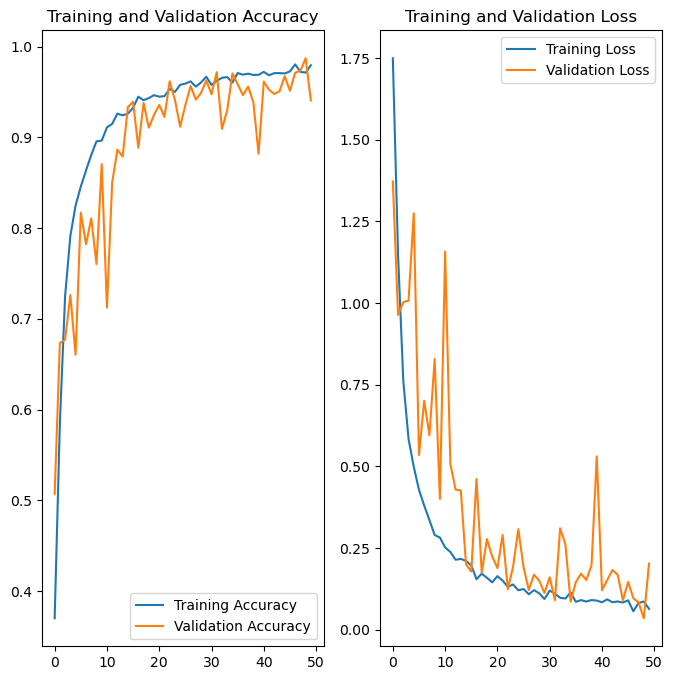

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### 6. Model evaluation

In [ ]:
# evaluating model using testing set
metrics = model.evaluate(test_ds)
print(f'Loss : {round(100 * metrics[0], 2)}%')
print(f'Acc  : {round(100 * metrics[1], 2)}%')

51/51 [==============================] - 90s 338ms/step - loss: 0.2510 - accuracy: 0.9187
Loss : 25.1%
Acc  : 91.87%


In [ ]:
# predicting labels of testing set and getting their confidences
lbls_true = []
lbls_pred = [] # predicted integer labels
pred_confs = [] # confidences

for i in range(test_size):
    for imgs, lbls in test_ds.take(i + 1):
        lbls_true.extend(lbls.numpy().tolist())

        pred_imgs = model.predict(imgs)
        for pred_img in pred_imgs:
            lbls_pred.append(np.argmax(pred_img))
            pred_confs.append(np.max(pred_img))
        break


1/1 [==============================] - 0s 222ms/step


In [ ]:
# changing integer labels to class names
lbls_true_names = list(map(lambda x: class_names[x], lbls_true))
lbls_pred_names = list(map(lambda x: class_names[x], lbls_pred))

In [ ]:
# getting confusion matrix
cf_matrix = confusion_matrix(lbls_true_names, lbls_pred_names, labels=class_names)
cf_matrix_title = 'Confusion Matrix using Test Set'
print(cf_matrix_title)
print(cf_matrix)

Confusion Matrix using Test Set
[[188   1   0   2   0   0   0   0   9   3]
 [  0  81   3   5   0   4  16   0   3   0]
 [  0   0 181   0   0   0   0   0   0   0]
 [  0   3   3 148   0   0   8   0   0   0]
 [  0   0   1   1 102   0   5   0   0   0]
 [  0   0   0   0   0  36   0   0   0   0]
 [  0   0   4   1   1   0 155   0   0   0]
 [  0   0  25   0   0   0   0 136   9   0]
 [  0   0  21   0   0   0   2   7 119   0]
 [  0   0   0   0   0   2   0   1   0 304]]


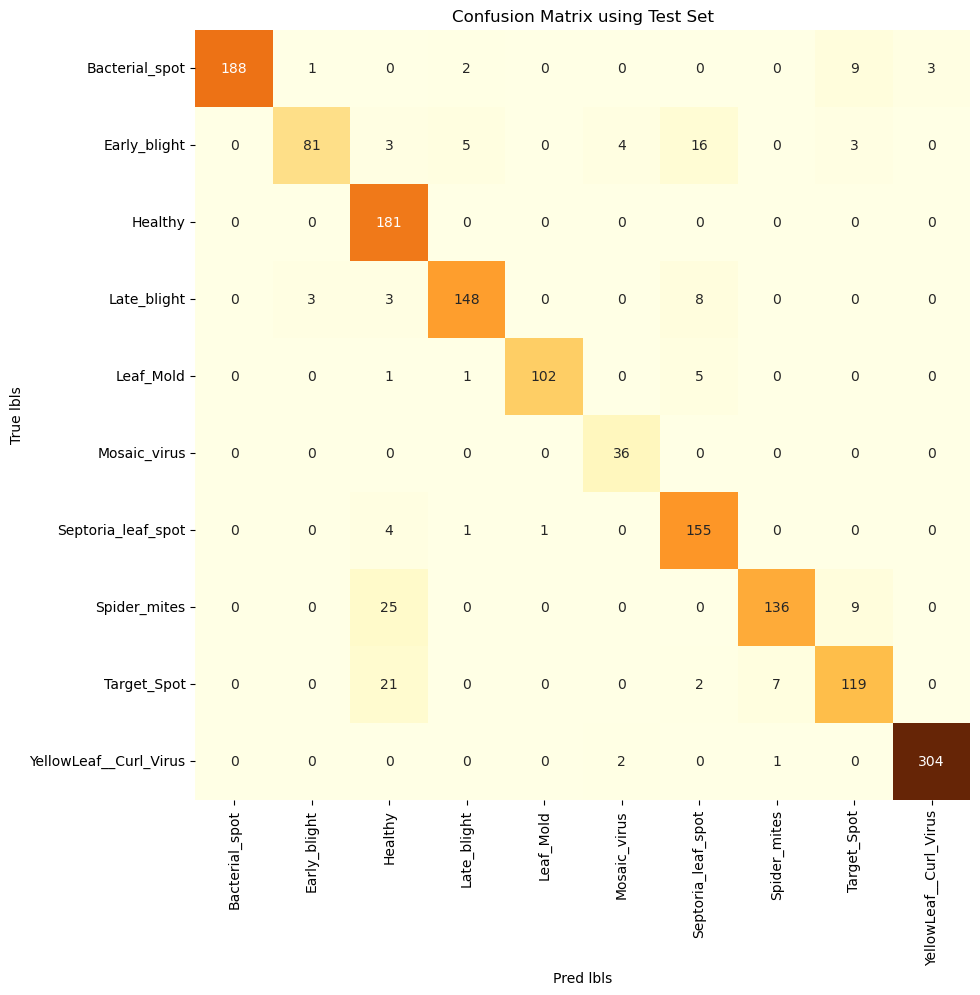

In [ ]:
#plotting confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cf_matrix, annot=True, fmt='g',
            xticklabels=class_names, yticklabels=class_names,
            cbar=False, cmap='YlOrBr')
plt.xlabel('Pred lbls')
plt.ylabel('True lbls')
plt.title(cf_matrix_title)
plt.show()


In [ ]:
# getting precisions
pred_sums = np.sum(cf_matrix, axis=0)
prec_matrix = cf_matrix / pred_sums
precs = prec_matrix.diagonal()

# getting recalls
true_sums = np.sum(cf_matrix, axis=1)
recall_matrix = cf_matrix / true_sums
recalls = recall_matrix.diagonal()

# getting f1 measures
f1s = (2 * precs * recalls) / (precs + recalls)


In [ ]:
# displaying testing set counts
counts_tbl = []
for i in range(len(class_names)):
    counts_tbl.append([class_names[i], true_sums[i]])
counts_tbl.append(['Test set', sum(true_sums)])

print('Test set counts:')
print(tabulate(counts_tbl, tablefmt='grid'))

Test set counts:
+------------------------+------+
| Bacterial_spot         |  203 |
+------------------------+------+
| Early_blight           |  112 |
+------------------------+------+
| Healthy                |  181 |
+------------------------+------+
| Late_blight            |  162 |
+------------------------+------+
| Leaf_Mold              |  109 |
+------------------------+------+
| Mosaic_virus           |   36 |
+------------------------+------+
| Septoria_leaf_spot     |  161 |
+------------------------+------+
| Spider_mites           |  170 |
+------------------------+------+
| Target_Spot            |  149 |
+------------------------+------+
| YellowLeaf__Curl_Virus |  307 |
+------------------------+------+
| Test set               | 1590 |
+------------------------+------+


In [ ]:
# displaying evaluations
evals_df = pd.DataFrame(data={'Precision': precs, 'Recall': recalls, 'F1': f1s},
                        index=class_names)
pd.options.display.float_format = '{:.2%}'.format
evals_df

,Precision,Recall,F1
Bacterial_spot,100.00%,92.61%,96.16%
Early_blight,95.29%,72.32%,82.23%
Healthy,76.05%,100.00%,86.40%
Late_blight,94.27%,91.36%,92.79%
Leaf_Mold,99.03%,93.58%,96.23%
Mosaic_virus,85.71%,100.00%,92.31%
Septoria_leaf_spot,83.33%,96.27%,89.34%
Spider_mites,94.44%,80.00%,86.62%
Target_Spot,85.00%,79.87%,82.35%
YellowLeaf__Curl_Virus,99.02%,99.02%,99.02%


In [ ]:
macro_f1 = round(evals_df['F1'].mean() * 100, 2)
micro_f1 = round(np.sum(cf_matrix.diagonal()) / np.sum(cf_matrix) * 100, 2)
print(f'Macro F1: {macro_f1}%')
print(f'Micro F1: {micro_f1}%')

Macro F1: 90.35%
Micro F1: 91.19%


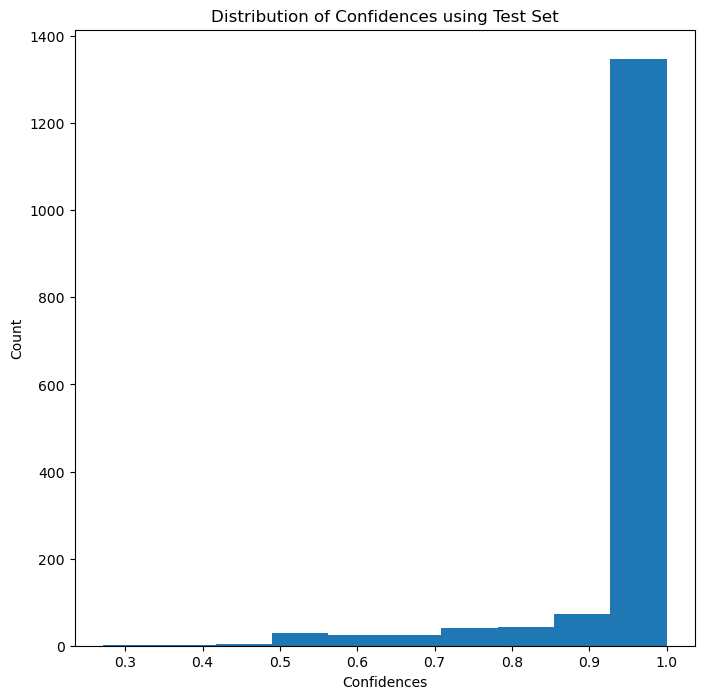

In [ ]:
# plotting distribution of confidences
plt.figure(figsize=(8, 8))
plt.hist(pred_confs)
plt.xlabel('Confidences')
plt.ylabel('Count')
plt.title('Distribution of Confidences using Test Set')
plt.show()


### Displaying random image results


first image to predict
actual label: Spider_mites
1/1 [==============================] - 0s 310ms/step
predicted label: Spider_mites


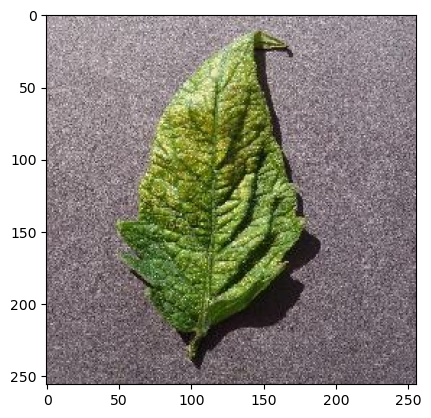

In [ ]:
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 122ms/step


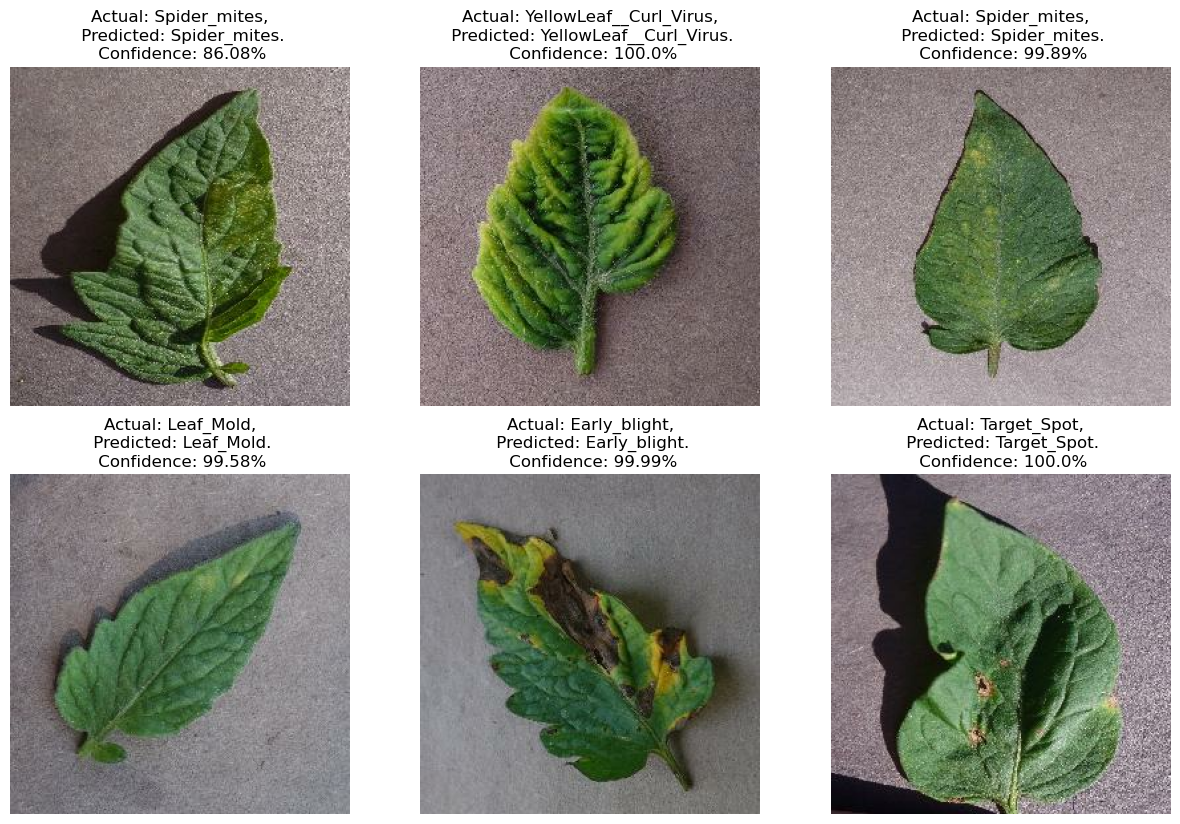

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(6):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
# saving latest model
models_dir = 'Models' # models directory
model_ver = len(os.listdir(models_dir)) # latest saved model
model_ver += 1
model.save(f'{models_dir}/{model_ver}')

INFO:tensorflow:Assets written to: Models/1\assets


INFO:tensorflow:Assets written to: Models/1\assets


In [ ]:
model.save("Tomato_disease_classification.h5")